In [1]:
import pickle as pkl
import numpy as np
from utils import *
import matplotlib.pyplot as plt


In [2]:
from physics_sim import *


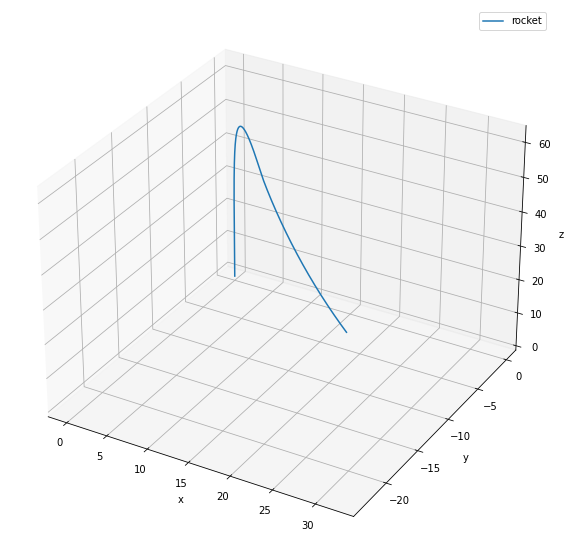

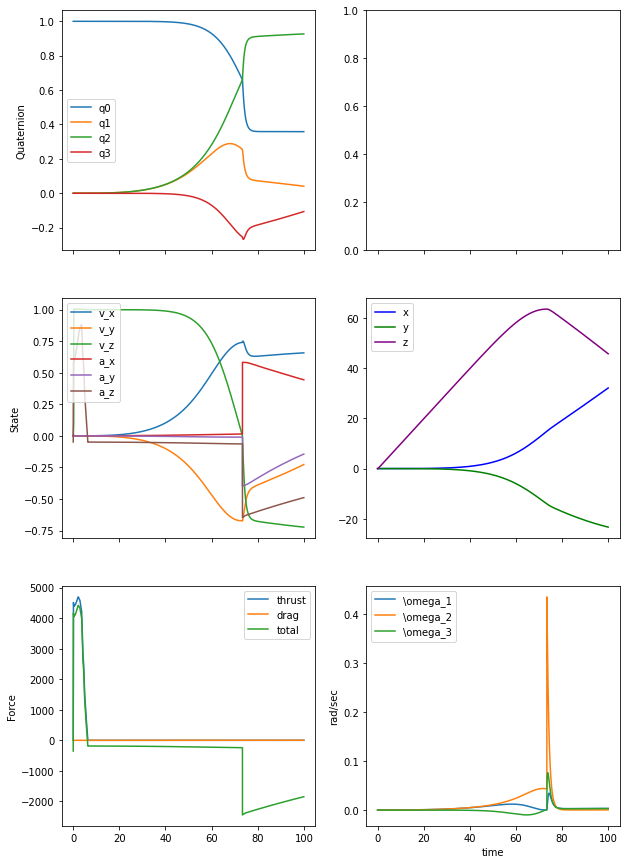

In [3]:
# initialize state

# quaternion initial conditions at 2 degrees
# initial_angle = 5 * np.pi / 180

# initial_q = np.array([np.cos(initial_angle / 2), 0, np.sin(initial_angle / 2), np.sin(initial_angle / 2)])
initial_q = np.array((1.0, 0.0, 0.0, 0.0)) 

u = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0,*initial_q,0,0,0])

state = State(u)

sensor_offset = np.array([0,-0.2,-0.5]) # location of the sensor relative to the tip
sensor_u = np.array([0,0,0, 0, 0, 0, 0, 0, 0,*initial_q,0,0,0])

total_time = 100
dt = 0.005

times = np.arange(0, total_time, dt)
states = []
thrusts = []
drags = []
total_forces = []




masses = []
for i, t in enumerate(times):
    if state.u[2] < 0 and i > 20:
      print("Sim should stop by", t, "seconds")
      break
    ## calculate forces ##
    
    relative_wind = (wind_vector(*state.u[:3])*100 - state.u[3:6])
    
    # calculate drag force
    if state.u[5] < 0:
        drag = calculate_drag(
            velocity = state.u[3:6],
            air_density = calculate_air_density(state.u[2]),
            C_d = 2.2,
            A_s = 2.63)
        drag_force = np.zeros(3) if np.linalg.norm(state.u[3:6]) < 1e-5 else -drag * state.u[3:6] / np.linalg.norm(state.u[3:6])
        wind = relative_wind.dot(relative_wind) * calculate_air_density(state.u[2]) * (2.63)
        
    else:
        drag = calculate_drag(
            velocity = state.u[3:6],
            air_density = calculate_air_density(state.u[2]),
            C_d = 0.37,
            A_s = 0.066)
        drag_force = np.zeros(3) if np.linalg.norm(state.u[3:6]) < 1e-5 else -drag * state.u[3:6] / np.linalg.norm(state.u[3:6])
        wind = relative_wind.dot(relative_wind) * calculate_air_density(state.u[2]) * (0.066)

    # multiply by normalized velocity vector
                            #np.zeros(3))
    drags.append(drag_force[2])
    # calculate thrust force
    thrust = f_thrust(t)
    thrusts.append(thrust)
    heading_vector = np.array([0.01,0.01,1]) if np.linalg.norm(state.u[3:6]) < 1e-1 else state.u[3:6] 
    heading_vector /= np.linalg.norm(heading_vector)
    thrust_force = heading_vector * thrust
    
    # calculate gravity force
    gravity = np.array([0, 0, -9.81]) * state.m_tot
    masses.append(state.m_tot)
    
    wind_force = np.zeros(3, ) if np.linalg.norm(state.u[3:6]) < 1e-5 else wind * relative_wind / np.linalg.norm(relative_wind)
    
    total_force = drag_force + thrust_force + gravity + wind_force
    total_forces.append(total_force[2])
    
    
    roll_torque = 1 * state.u[5]
    
    
    state.update_state(dt, forces = total_force, roll_torque = roll_torque)    
    states.append(state.u)

#exit()
# plotting results
fig1 = plt.figure(figsize=(10, 10))
position = fig1.add_subplot(111, projection='3d')
position.plot([state[0] for state in states], [state[1] for state in states], [state[2] for state in states],label='rocket')
position.set_xlabel('x')
position.set_ylabel('y')
position.set_zlabel('z')
plt.legend()
plt.show()

# Second Plot: Subplots sharing the same x-axis
fig2, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(10, 15), sharex=True)
ax0.plot(times, [state[9] for state in states], label='q0')
ax0.plot(times, [state[10] for state in states], label='q1')
ax0.plot(times, [state[11] for state in states], label='q2')
ax0.plot(times, [state[12] for state in states], label='q3')
ax0.legend()
ax0.set_ylabel('Quaternion')


ax3.plot(times, [state[0] for state in states], label='x', color = 'blue')
ax3.plot(times, [state[1] for state in states], label='y', color = 'green')
ax3.plot(times, [state[2] for state in states], label='z', color = 'purple')
ax3.legend()

ax2.plot(times, [state[3] for state in states], label='v_x')
ax2.plot(times, [state[4] for state in states], label='v_y')
ax2.plot(times, [state[5] for state in states], label='v_z')
ax2.plot(times, [state[6] for state in states], label='a_x')
ax2.plot(times, [state[7] for state in states], label='a_y')
ax2.plot(times, [state[8] for state in states], label='a_z')
ax2.legend()
ax2.set_ylabel('State')

# Subplot 2: x,y,z acceleration over time
ax4.plot(times, thrusts, label="thrust")
ax4.plot(times, drags, label="drag")
ax4.plot(times, total_forces, label="total")
ax4.set_ylabel('Force')
ax4.legend()

# Subplot 3: omega1, omega2, omega3 over time
ax5.plot(times[:len(states)], [state[13] for state in states], label='\\omega_1')
ax5.plot(times[:len(states)], [state[14] for state in states], label='\\omega_2')
ax5.plot(times[:len(states)], [state[15] for state in states], label='\\omega_3')
ax5.set_xlabel('time')
ax5.set_ylabel('rad/sec')
ax5.legend()
plt.show()


## Import data into the sensor modeling section

In [4]:
sim_state_history = np.array(states)
sim_state_history.shape


(20000, 16)

In [5]:
print(sim_state_history[0:2, 3:9])


[[ 0.          0.          0.          0.          0.         -0.04905136]
 [ 0.          0.          0.00010116  0.00069286  0.00069286  0.02023228]]


In [6]:
def add_noise(mean, var):
    return np.random.normal(mean, var)


In [7]:
# define sensor relative position
sensor_pos = np.array([0.5, 0.0, -1])

def sensor_from_cg(t,sensor_pos):
    com = cg(t)
    return com + sensor_pos

sensor_from_cg(0, sensor_pos)


array([1.97144457, 1.47144457, 0.47144457])

In [8]:
import sys
sys.path.append("..")

from src.PredictorProvider import LinearPredictorProvider, UnscentedPredictorProvider
from src.CorrectorProvider import LinearCorrectorProvider, UnscentedCorrectorProvider

import quaternion

NUM_STATES = 16


## Obs Models

In [9]:
class GPSCorrector(LinearCorrectorProvider):
  def linear_obs_mat(self, state):
    # The three vec of pos is what we observe
    return np.block([np.eye(3), np.zeros((3, 13))]) 


In [10]:
class BaroCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    height = state[2, :]

    # Constants for the barometric formula
    g = 9.80665  # Acceleration due to gravity (m/s^2)
    M = 0.0289644  # Molar mass of Earth's air (kg/mol)
    R = 8.31432  # Universal gas constant (J/(mol*K))
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)

    # Calculate the temperature at the given height
    temperature = T0 - 0.0065 * height

    # Calculate the pressure using the barometric formula
    pressure = P0 * np.power((1 - (0.0065 * height) / T0), (g * M) / (R * 0.0065)) / 1e3

    return np.vstack((pressure, temperature))
  

In [11]:
IMU_RADIUS = np.array([[1.97144457, 1.47144457, 0.47144457]])

class AccelCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    g = 9.80665  # Acceleration due to gravity (m/s^2)

    # accel includes gravity
    accel = state[6:9, :] + np.array([[0, 0, g]]).T
    
    q = quaternion.as_quat_array(state[9:13, :].T)
    q /= np.sqrt(q * q.conjugate())

    omega = quaternion.as_vector_part(q.conj() * quaternion.from_vector_part(state[13:16, :].T) * q)

    # Rotate the acceleration vector from global to the body frame
    body_accel = quaternion.as_vector_part(q.conj() * quaternion.from_vector_part(accel.T) * q)
    
    # Subtract the centripetal acceleration
    inner_cross = np.cross(omega, IMU_RADIUS)
    outer_cross = np.cross(omega, inner_cross)
    sensor_accel = body_accel - outer_cross
    
    return sensor_accel.T


In [12]:
test_corrector = AccelCorrector(np.eye(3), noise_lerp=0.0, num_states=NUM_STATES)

test_corrector.obs_pred(np.ones((NUM_STATES, 33))
).shape


(3, 33)

In [13]:
class OmegaCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    q = quaternion.as_quat_array(state[9:13, :].T)
    q /= np.sqrt(q * q.conjugate())
    omega = state[13:16, :]

    # Rotate the angular velocity vector from global to the body frame
    body_omega = quaternion.as_vector_part(q.conj() * quaternion.from_vector_part(omega.T) * q).T

    return body_omega


In [14]:
test_corrector = OmegaCorrector(np.eye(3), noise_lerp=0.0, num_states=NUM_STATES)

test_corrector.obs_pred(np.ones((NUM_STATES, 33))
).shape


(3, 33)

In [15]:
class MagCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    orient = quaternion.as_quat_array(state[9:13, :].T)
    orient /= np.sqrt(orient * orient.conjugate())
    

    # Y is "north"
    # orient takes a vector in the basis of the body frame and returns the corresponding world space vecotor 

    # Rotate the magnetic field vector from global to the body frame
    body_mag = quaternion.as_vector_part(orient.conj() * quaternion.from_vector_part(np.array([[0, 1, 0]])) * orient).T

    return body_mag


In [16]:

gps_noise = np.diag(3 * np.ones(3, ))

baro_noise = np.diag(np.array((0.06, 0.01)))

g = 9.80665  # Acceleration due to gravity (m/s^2)
accel_noise = np.diag(g * 529000e-6 * np.ones(3, ))
gyro_noise = np.diag(0.00225 * np.pi / 180 * np.ones(3, ))

mag_noise = np.diag(1e-7 * np.ones(3, ))

# Init the predictors and correctors


gps_corrector = GPSCorrector(gps_noise, noise_lerp=0.0)

baro_corrector = BaroCorrector(baro_noise, noise_lerp=0.0, num_states=NUM_STATES)
accel_corrector = AccelCorrector(accel_noise, noise_lerp=0.0, num_states=NUM_STATES)
omega_corrector = OmegaCorrector(gyro_noise, noise_lerp=0.0, num_states=NUM_STATES)

mag_corrector = MagCorrector(mag_noise, noise_lerp=0.0, num_states=NUM_STATES)


## Part 2: Generating Sensor Data

In [17]:
# add noise to sensor data
accel_var = 529000 # µg
gyro_var = 0.00225 # d/s

# convert to m/s^2
accel_var *= 9.81/1e6
gyro_var *= np.pi/180

sens_accel = accel_corrector.obs_pred(sim_state_history.T) 

sens_gyro = omega_corrector.obs_pred(sim_state_history.T) 

sens_accel_noisy = sens_accel.T + np.sqrt(gyro_var) * np.random.randn(len(times), 3)
sens_gyro_noisy = sens_gyro.T + np.sqrt(gyro_var) * np.random.randn(len(times), 3)


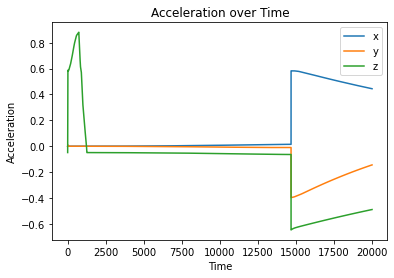

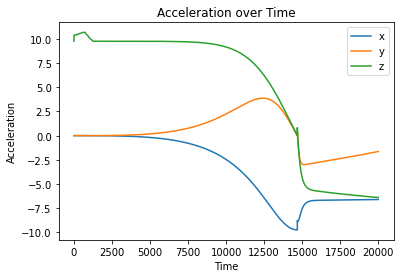

In [18]:
plt.plot(sim_state_history[:, 6:9], label=('x', 'y', 'z'))
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.legend()
plt.show()



plt.plot(sens_accel.T, label=('x', 'y', 'z'))
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.legend()
plt.show()


In [19]:
accel_corrector.obs_pred(sim_state_history[100:101, :].T)


array([[ 9.89257290e-07],
       [-9.92595522e-07],
       [ 1.04046629e+01]])

In [20]:
print(sim_state_history[6, :])


[0.00000000e+00 0.00000000e+00 5.67733687e-05 0.00000000e+00
 0.00000000e+00 5.80862621e-03 4.16237567e-03 4.16237567e-03
 3.67169863e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [21]:
print(sens_accel[:, 0])


[0.         0.         9.75759864]


In [22]:
print(sens_accel_noisy[:, 0])


[-4.83844394e-04  4.94504782e-03  5.90888810e-03 ... -6.59716250e+00
 -6.59776741e+00 -6.59349531e+00]


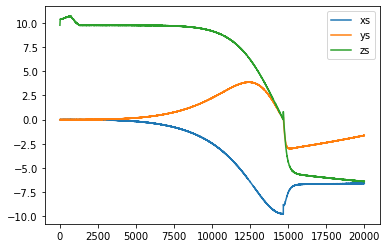

In [23]:
# plot noisy sensor data
plt.plot(np.array(sens_accel_noisy)[:,0],label='xs')
plt.plot(np.array(sens_accel_noisy)[:,1],label='ys')
plt.plot(np.array(sens_accel_noisy)[:,2],label='zs')
plt.legend()
plt.show()


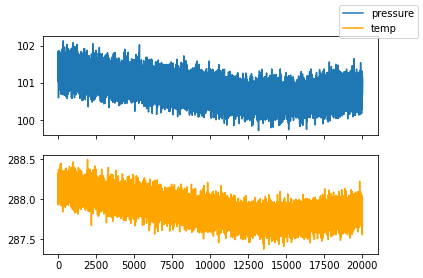

In [24]:
baro_data = baro_corrector.obs_pred(sim_state_history.T).T
baro_data_noisy = baro_data + np.hstack((np.sqrt(baro_noise[0, 0]) * np.random.randn(len(times), 1), np.sqrt(baro_noise[1, 1]) * np.random.randn(len(times), 1)))

ps = baro_data_noisy[:,0]
ts = baro_data_noisy[:,1]

fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
ax1.plot(ps,label='pressure')
ax2.plot(ts,label='temp',color='orange')
fig.legend()
plt.show()


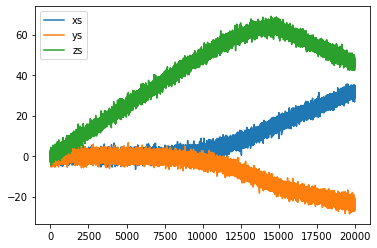

In [25]:
# generate GPS data (assume cartesian coordinates)
noisy_x = gps_corrector.obs_pred(sim_state_history.T).T + np.sqrt(gps_noise[0, 0]) * np.random.randn(len(times), 3)

plt.plot(np.array(noisy_x)[:,0],label='xs')
plt.plot(np.array(noisy_x)[:,1],label='ys')
plt.plot(np.array(noisy_x)[:,2],label='zs')
plt.legend() 
plt.show()


In [26]:
orientation_sense = mag_corrector.obs_pred(sim_state_history.T) + np.sqrt(mag_noise[0, 0]) * np.random.randn(3, len(times))
print(orientation_sense.shape)


(3, 20000)


In [27]:
accel_sense = sens_accel_noisy
gyro_sense = sens_gyro_noisy

baro_sense = baro_data_noisy
gps_sense = noisy_x
mag_sense = orientation_sense


# Filtering the Data

## Evo Model

In [28]:

class BlackBoxPredictor(UnscentedPredictorProvider):
  def point_prop(self, state, dt):
    h_dt = dt**2 / 2

    pos = state[0:3]
    vel = state[3:6]
    accel = state[6:9]

    q = quaternion.as_quat_array(state[9:13, :].T)
    q /= np.sqrt(q * q.conjugate())
    omega = state[13:16, :]

    
    pos_prime = pos + dt * vel + h_dt * accel
    vel_prime = vel + dt * accel
    accel_prime = accel

    rotated_q = quaternion.from_rotation_vector(dt * omega.T) * q
    rotated_q /= np.sqrt(rotated_q * rotated_q.conjugate())

    q_prime = quaternion.as_float_array(rotated_q.T).T
    
    omega_prime = omega
    
    return np.concatenate((pos_prime, vel_prime, accel_prime, q_prime, omega_prime))



In [29]:
bbp = BlackBoxPredictor(np.eye(NUM_STATES), 0.0, num_states=NUM_STATES)
out = bbp.point_prop(sim_state_history[0:1, :].T, 0.01)
q = quaternion.as_quat_array(out[9:13, :].T)
q


array([quaternion(1, 0, 0, 0)], dtype=quaternion)

In [30]:
print(q * q.conjugate())


[quaternion(1, 0, 0, 0)]


## Setting up the filter

In [31]:

process_noise = 1e-7 * np.eye(NUM_STATES)
process_noise[0:3, 0:3] += 1e-5 * np.eye(3)
# process_noise[3:6, 3:6] += 1e-4 * np.eye(3)
process_noise[6:9, 6:9] += 1e-3 * np.eye(3)

process_noise[9:13, 9:13] += 1e-7 * np.eye(4)
process_noise[13:16, 13:16] += 1e-6 * np.eye(3)

# Note: Noise lerp is sort of an abandoned experiment (the filter estimates the sensor and process cov based off of an exponential filter) 
# setting it to 0.0 means that the filter will use the provided noise matrices without modification
state_predictor = BlackBoxPredictor(process_noise, noise_lerp=0.0, num_states=NUM_STATES)


## Running the filter

In [32]:
starting_state = np.array([0, 0, 0,
                           0, 0, 0,
                           0, 0, 0,
                           1, 0, 0, 0,
                           0, 0, 0])


In [33]:
state_history = np.zeros((NUM_STATES, len(times)))
cov_history = np.zeros((NUM_STATES, NUM_STATES, len(times)))

state = starting_state
# cov = np.random.rand(NUM_STATES, NUM_STATES)
# cov += cov.T 
# cov /= 1e3

# cov += np.eye(NUM_STATES) * 1e-7



cov = np.eye(NUM_STATES) * 1e-3

for ind, t in enumerate(times):
  print("ind: ", ind, end='\r')
  state, cov = state_predictor.predict(state, cov, dt)

  
  if ind % 100 == 0:
    state, cov = gps_corrector.correct(state, cov, gps_sense[ind, :], state_predictor)

  state, cov = baro_corrector.correct(state, cov, baro_sense[ind, :], state_predictor)

  state, cov = accel_corrector.correct(state, cov, accel_sense[ind, :], state_predictor)
  
  state, cov = mag_corrector.correct(state, cov, mag_sense[:, ind], state_predictor) 

  state, cov = omega_corrector.correct(state, cov, gyro_sense[ind, :], state_predictor)

  state_history[:, ind] = state
  cov_history[:, :, ind] = cov


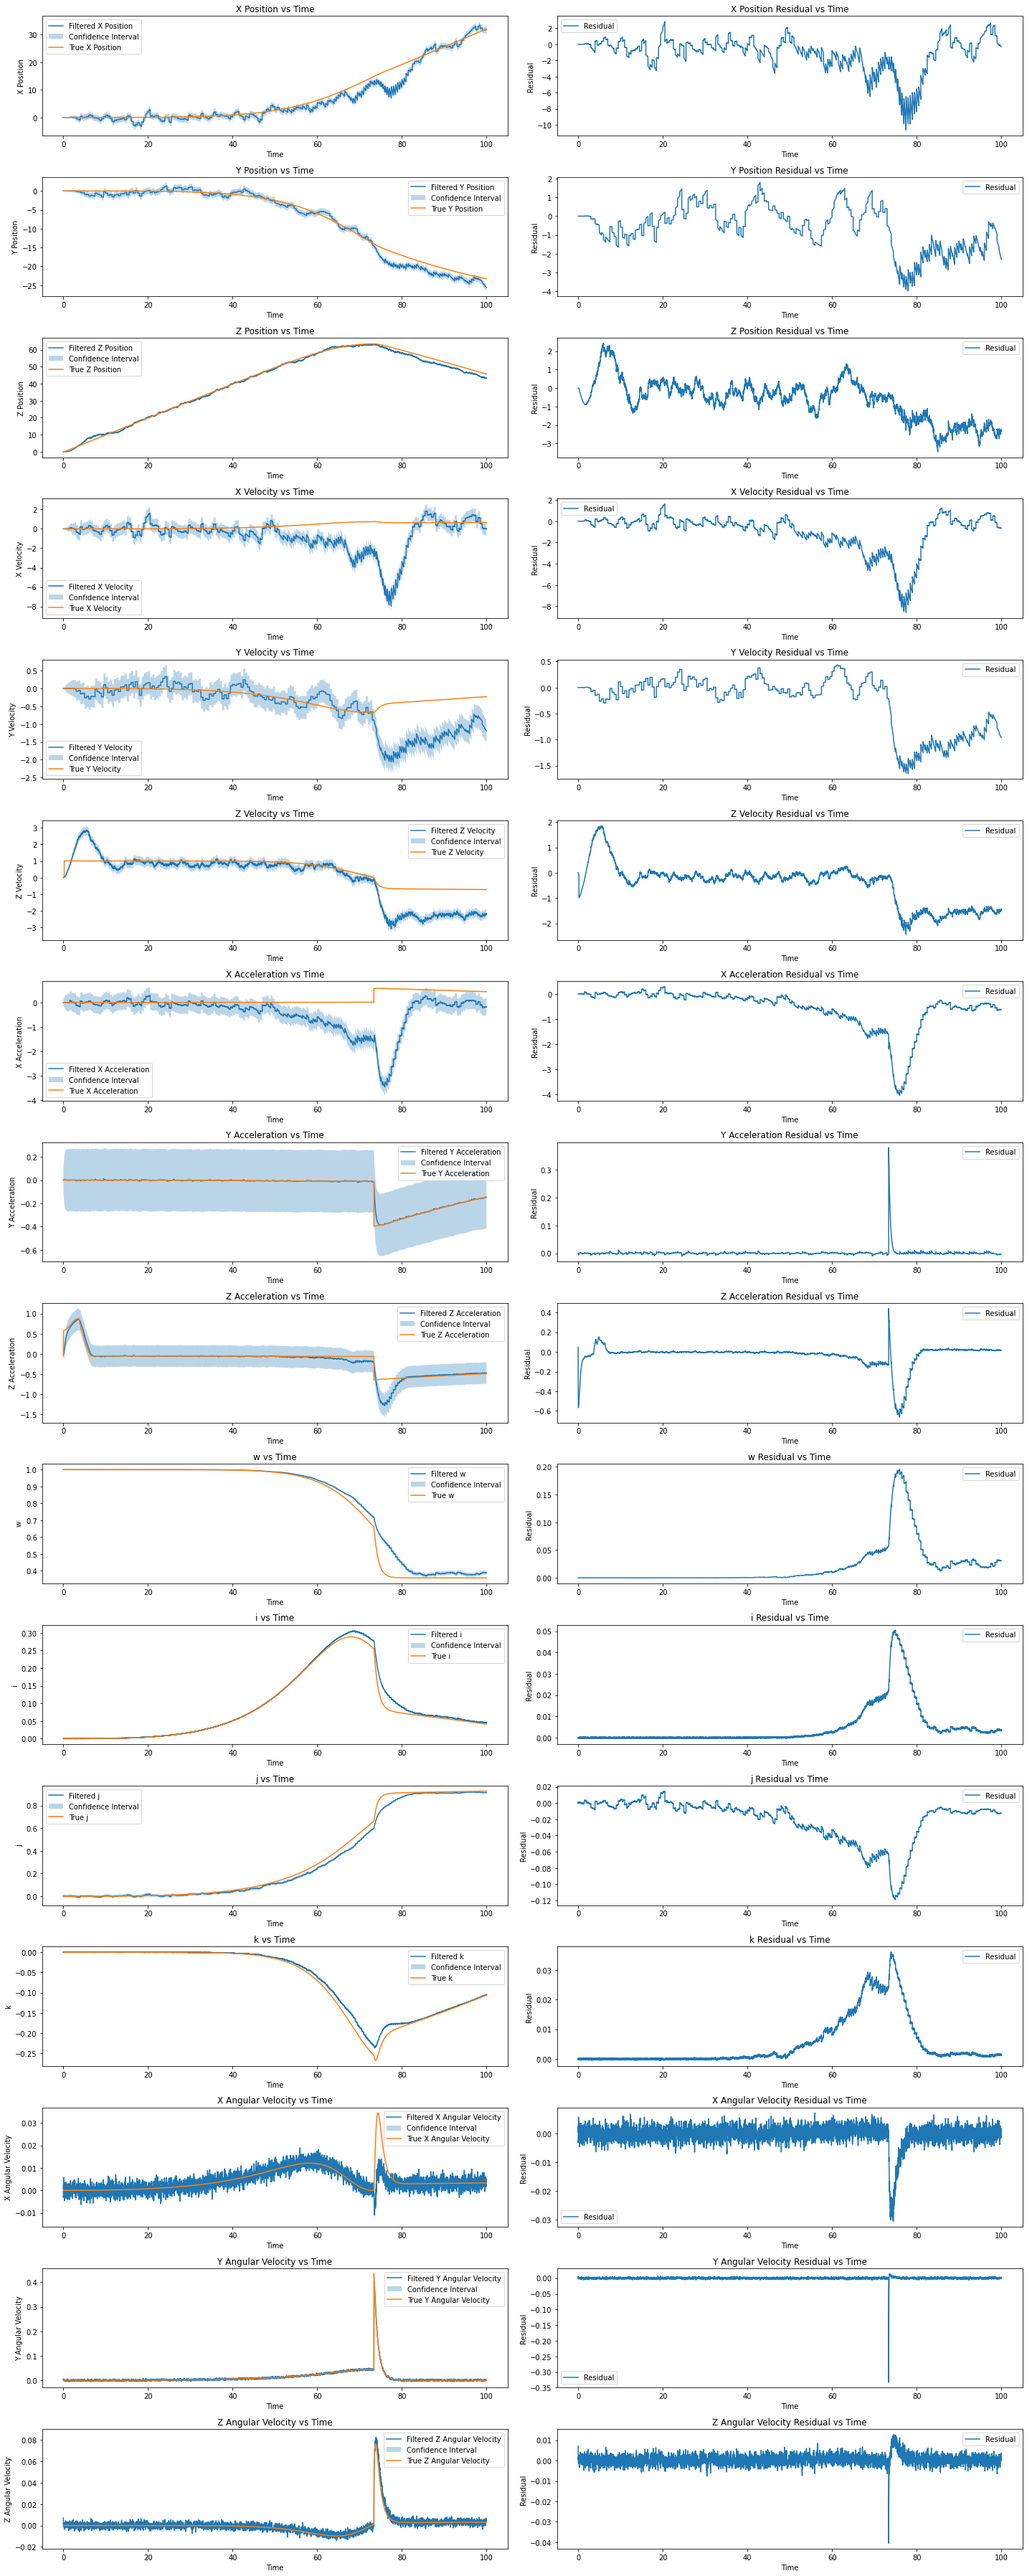

In [34]:
# Plotting position, velocity, acceleration, state variance, and residual over time
fig, axs = plt.subplots(3 * 3 + 4 + 3, 2, figsize=(20, 50))

for ind, label in enumerate(["X Position", "Y Position", "Z Position", "X Velocity", "Y Velocity", "Z Velocity", "X Acceleration", "Y Acceleration", "Z Acceleration", "w", "i", "j", "k", "X Angular Velocity", "Y Angular Velocity", "Z Angular Velocity"]):
  # Plotting position vs time
  axs[ind, 0].plot(times, state_history[ind, :], label='Filtered {}'.format(label))
  axs[ind, 0].fill_between(times, state_history[ind, :] - np.sqrt(cov_history[ind, ind, :]),
            state_history[ind, :] + np.sqrt(cov_history[ind, ind, :]),
            alpha=0.3, label='Confidence Interval')
  
  axs[ind, 0].plot(times[:], sim_state_history[:, ind], label='True {}'.format(label))
  
  axs[ind, 0].set_xlabel('Time')
  axs[ind, 0].set_ylabel(label)
  axs[ind, 0].set_title('{} vs Time'.format(label))
  axs[ind, 0].legend()

  # Plotting residual vs time
  axs[ind, 1].plot(times, state_history[ind, :] - sim_state_history[:, ind], label='Residual')
  axs[ind, 1].set_xlabel('Time')
  axs[ind, 1].set_ylabel('Residual')
  axs[ind, 1].set_title('{} Residual vs Time'.format(label))
  axs[ind, 1].legend()

plt.tight_layout()
plt.show()


In [35]:
# %matplotlib widget
from matplotlib import rc
rc('animation', html='html5')

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation


STRIDE = 100

fig, ax = plt.subplots(figsize=(25, 25))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(cov_history[:, :, 0], cmap='viridis', interpolation='nearest')
fig.colorbar(im, cax=cax, orientation='vertical')  # Add colorbar

def animate(i):
  print("Animating frame {} of {}".format(i, len(times[::STRIDE])), end='\r')
  ax.clear()
  im = ax.imshow(cov_history[:, :, i * STRIDE], cmap='viridis', interpolation='nearest')
  ax.set_title('Covariance Matrix at Time Step {}'.format(i))
  ax.set_xlabel('State Dimension')
  ax.set_ylabel('State Dimension')


# ani = animation.FuncAnimation(fig, animate, frames=len(times[::STRIDE]), interval=10, blit=False)
plt.close()
# ani


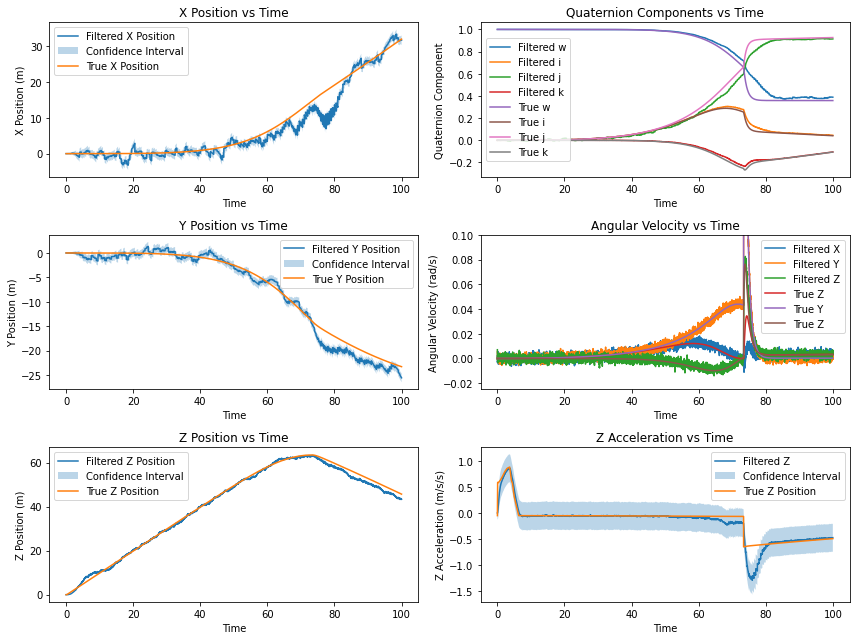

In [41]:
# Plotting position, velocity, acceleration, state variance, and residual over time
fig, axs = plt.subplots(3, 2, figsize=(12, 9))

for ind, label in enumerate(["X Position", "Y Position", "Z Position"]):
  # Plotting position vs time
  axs[ind, 0].plot(times, state_history[ind, :], label='Filtered {}'.format(label))
  axs[ind, 0].fill_between(times, state_history[ind, :] - np.sqrt(cov_history[ind, ind, :]),
            state_history[ind, :] + np.sqrt(cov_history[ind, ind, :]),
            alpha=0.3, label='Confidence Interval')
  
  axs[ind, 0].plot(times[:], sim_state_history[:, ind], label='True {}'.format(label))
  
  axs[ind, 0].set_xlabel('Time')
  axs[ind, 0].set_ylabel(label + " (m)")
  axs[ind, 0].set_title('{} vs Time'.format(label))
  axs[ind, 0].legend()

axs[0, 1].plot(times, state_history[9:13, :].T, label=('Filtered w', 'Filtered i', 'Filtered j', 'Filtered k'))
axs[0, 1].plot(times, sim_state_history[:, 9:13], label=('True w', 'True i', 'True j', 'True k'))
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Quaternion Component')
axs[0, 1].set_title('Quaternion Components vs Time')
axs[0, 1].legend(loc='center left')

axs[1, 1].plot(times, state_history[13:, :].T, label=('Filtered X', 'Filtered Y', 'Filtered Z'))
axs[1, 1].plot(times, sim_state_history[:, 13:], label=('True Z', 'True Y', 'True Z'))
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Angular Velocity (rad/s)')
axs[1, 1].set_title('Angular Velocity vs Time')
axs[1, 1].set_ylim([-0.025, 0.1])
axs[1, 1].legend()

axs[2, 1].plot(times, state_history[8, :], label='Filtered Z')
axs[2, 1].fill_between(times, state_history[8, :] - np.sqrt(cov_history[8, 8, :]),
          state_history[8, :] + np.sqrt(cov_history[8, 8, :]),
          alpha=0.3, label='Confidence Interval')

axs[2, 1].plot(times[:], sim_state_history[:, 8], label='True {}'.format(label))

axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('Z Acceleration (m/s/s)')
axs[2, 1].set_title('Z Acceleration vs Time')
axs[2, 1].legend()

plt.tight_layout()
plt.show()
